In [314]:
import baccoemu
import chainconsumer
import dynesty
import gc
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from multiprocessing import Pool, cpu_count

import emcee
import os
import pandas as pd
import time

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
#import sbi_tools
import plot_utils
#import scripts
# from scripts import sbi_tools
#from scripts import plot_utils
import generate_emuPks as genP

from momentnetworks import demo

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [315]:
plot_dir = '../plots/plots_2024-02-19'
save_plots = True

tag_fit = '_cosmolib'

In [316]:
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))
os.environ["OMP_NUM_THREADS"] = "1"

48 CPUs


In [317]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'
#N_threads = sbi_tools.set_N_threads(6)

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 

### Load data

In [318]:
param_names_all = ['omega_cold', 'sigma_8', 'h', 'omega_baryon', 'n_s', 'seed']
param_names = ['omega_cold', 'sigma_8', 'h']
param_names_fixed = [name for name in param_names_all if name not in param_names]
idxs_param_names = [param_names_all.index(name) for name in param_names]

#tag_pk = '_b1only'
tag_pk = '_b0000'
dir_pks = f'../data/pks_cosmolib/pks{tag_pk}'

n_lib = 500
dir_mocks = '../data/cosmolib'
theta = []
Pk = []
gaussian_error_pk = []
param_dict_fixed = {}
for idx_LH in range(n_lib):
    fn_fields = f'{dir_mocks}/LH{idx_LH}/Eulerian_fields_lr_{idx_LH}.npy'
    fn_params = f'{dir_mocks}/LH{idx_LH}/cosmo_{idx_LH}.txt'
    fn_pk = f'{dir_pks}/pk_{idx_LH}.npy'
    
    pk_obj = np.load(fn_pk, allow_pickle=True).item()
    Pk.append(pk_obj['pk'])
    gaussian_error_pk.append(pk_obj['pk_gaussian_error'])
    
    param_vals = np.loadtxt(fn_params)
    if idx_LH==0:
        for name in param_names_fixed:
            param_dict_fixed[name] = param_vals[param_names_all.index(name)]
    theta.append(param_vals[idxs_param_names])

Pk = np.array(Pk)
theta = np.array(theta)
gaussian_error_pk = np.array(gaussian_error_pk)

kk = pk_obj['k'] # all ks should be same so just grab one

In [319]:
n_tot = theta.shape[0]
n_params = theta.shape[1]

Plot P(k) data:

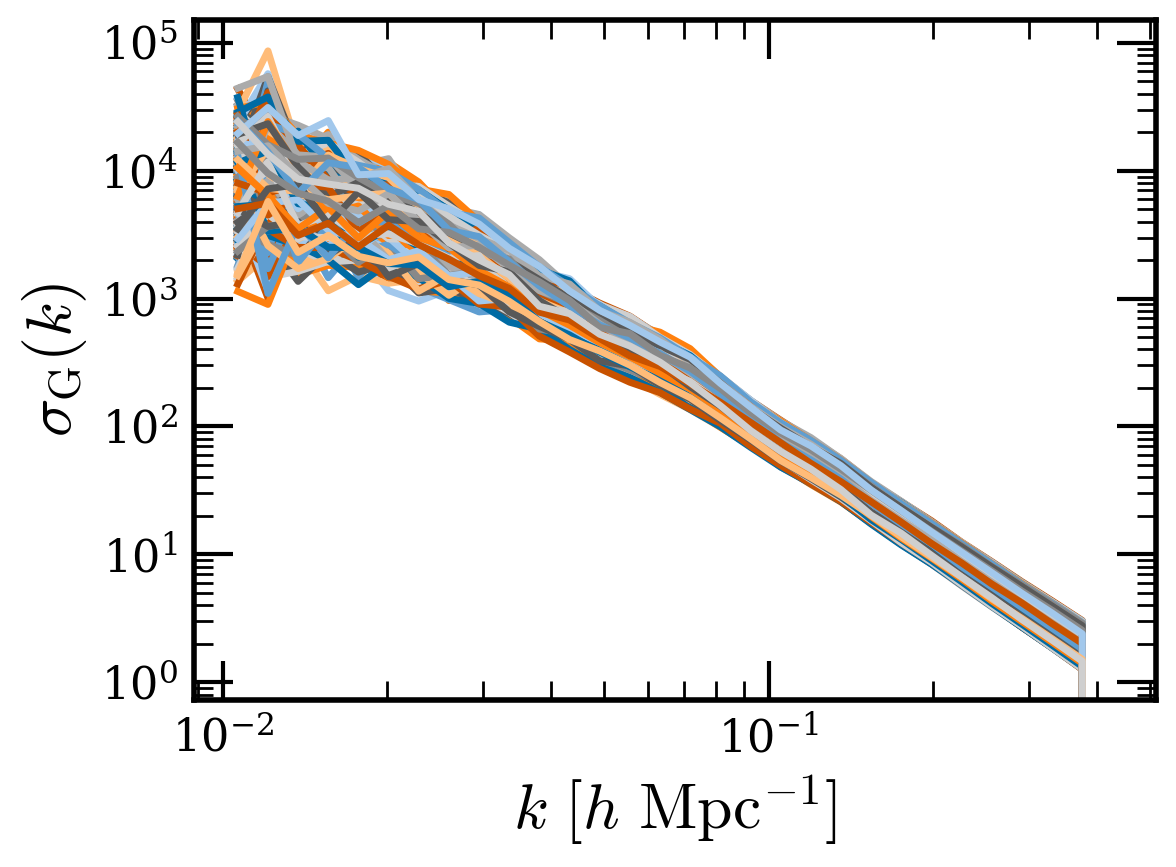

In [320]:
fig, ax = mpl.pyplot.subplots(figsize=(6, 4.5))
for iLH in range(n_tot):
    ax.loglog(kk, gaussian_error_pk[iLH])

ax.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=23)
ax.set_ylabel(r'$\sigma_\text{G}(k)$', fontsize=23)

mpl.pyplot.tight_layout()
mpl.pyplot.show()

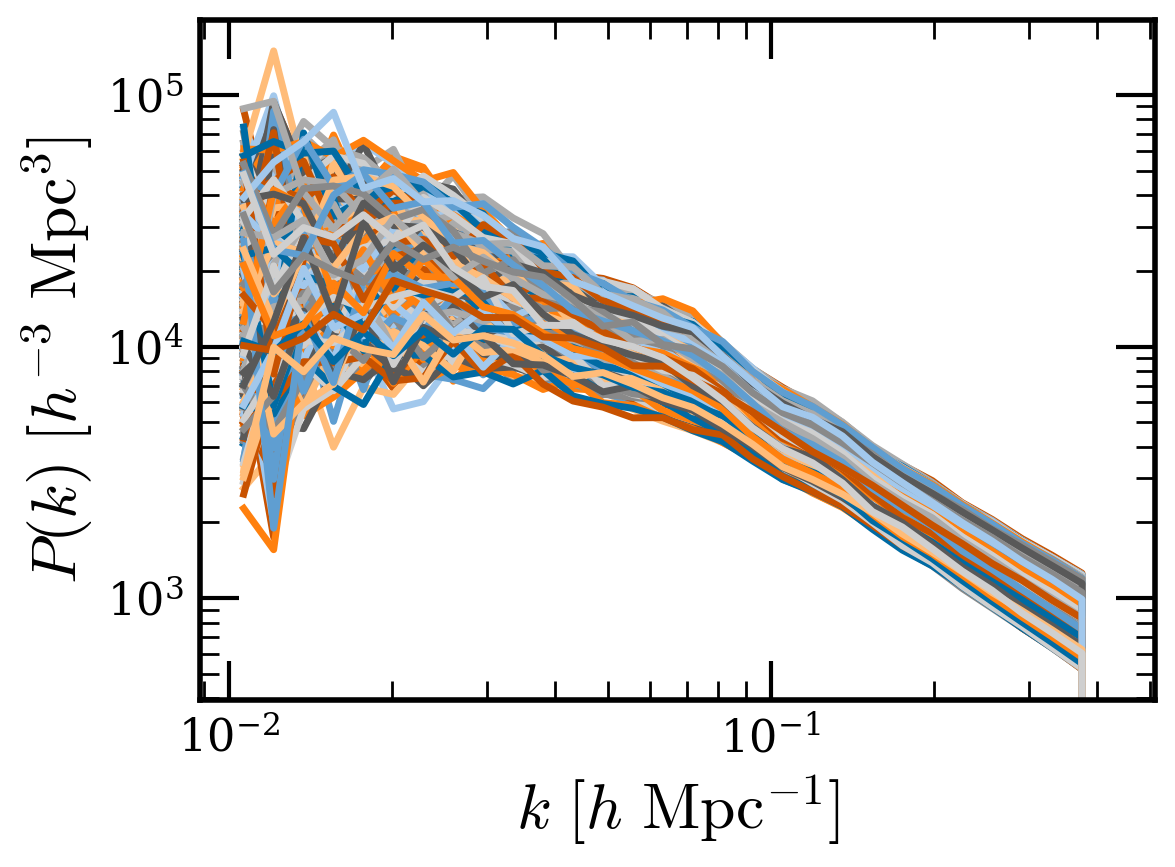

In [321]:
fig, ax = mpl.pyplot.subplots(figsize=(6, 4.5))
for iLH in range(n_tot):
    ax.loglog(kk, Pk[iLH])

ax.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=23)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=23)

mpl.pyplot.tight_layout()
mpl.pyplot.show()

In [322]:
#n_biasmodels = len(biases_vec)
n_biasmodels = 0
n_cosmos = n_params
print(n_biasmodels, n_cosmos)

0 3


Split into train-val-test

In [323]:
p_train, p_test = 0.8, 0.1
p_val = 1-p_train-p_test
train_split = int(theta.shape[0]*p_train)
test_split = int(theta.shape[0]*(1-p_test))
#train_val_split = int(n_biasmodels*round(theta.shape[0]*0.99/n_biasmodels))

theta_train = theta[:train_split]
theta_val = theta[train_split:test_split]
theta_test = theta[test_split:]
print(theta_train.shape, theta_val.shape, theta_test.shape)

(400, 3) (50, 3) (50, 3)


In [324]:
Pk_train = Pk[:train_split]
Pk_val = Pk[train_split:test_split]
Pk_test = Pk[test_split:]

mask = np.all(Pk_train>0, axis=0)
Pk_train = Pk_train[:,mask]
Pk_val = Pk_val[:,mask]
Pk_test = Pk_test[:,mask]
k = kk[mask]

gaussian_error_pk_train = gaussian_error_pk[:train_split][:,mask]
gaussian_error_pk_val = gaussian_error_pk[train_split:test_split][:,mask]
gaussian_error_pk_test = gaussian_error_pk[test_split:][:,mask]

In [325]:
n_dim = Pk_train.shape[1]
print(n_tot, n_params, n_dim)

500 3 29


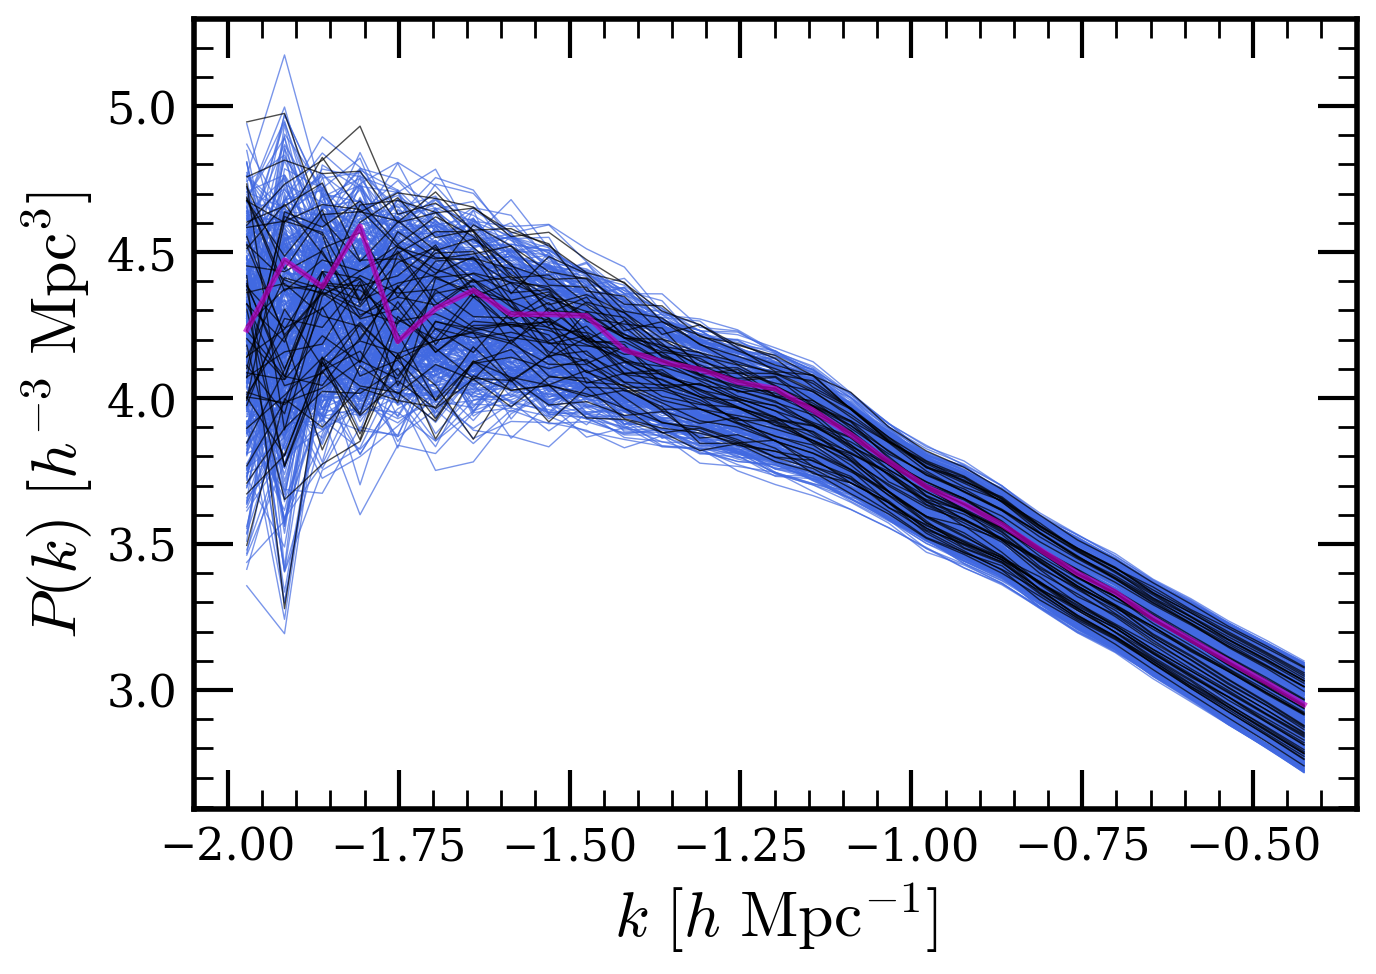

In [326]:
fig, ax = mpl.pyplot.subplots(1,1, figsize=(7,5))
fontsize = 24
fontsize1 = 18

alpha = 0.7

tmp_Pk_plot = Pk_train
tmp_Pk_plot = tmp_Pk_plot[np.random.choice(tmp_Pk_plot.shape[0], tmp_Pk_plot.shape[0], replace=False)].T
ax.plot(np.log10(k), np.log10(tmp_Pk_plot), c='royalblue', alpha=alpha, lw=0.5, label='training set')

tmp_Pk_plot = Pk_test
tmp_Pk_plot = tmp_Pk_plot[np.random.choice(tmp_Pk_plot.shape[0], tmp_Pk_plot.shape[0], replace=False)].T
ax.plot(np.log10(k), np.log10(tmp_Pk_plot), c='k', alpha=alpha, lw=0.5, label='test set')
    
ax.plot(np.log10(k), np.log10(Pk_test[0]), c='m', alpha=alpha, lw=2, label='test data')
    
ax.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=23)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=23)

mpl.pyplot.tight_layout()
mpl.pyplot.show()

In [327]:
dict_bounds = {}
for pp, param_name in enumerate(param_names):
    dict_bounds[param_name] = [np.min(theta[:,pp]), np.max(theta[:,pp])]

In [328]:
class Scaler:

    def __init__(self):
        pass
        
    def fit(self, x_train):
        self.x_train_min = np.min(x_train)
        self.x_train_max = np.max(x_train)

    def scale(self, x):
        log_x = np.log10(x)
        log_x_norm = (log_x - np.log10(self.x_train_min)) / (np.log10(self.x_train_max) - np.log10(self.    x_train_min))
        return log_x_norm
    
    def unscale(self, x_scaled):
        x = x_scaled * (np.log10(self.x_train_max) - np.log10(self.x_train_min)) + np.log10(self.x_train_min)
        return 10**x  
    
    def scale_error(self, err, x):
        # need 1/np.log(10) factor bc working in base 10
        dydx = 1./x * 1/np.log(10) * 1./(np.log10(self.x_train_max) - np.log10(self.x_train_min))
        err_scaled = np.sqrt(np.multiply(dydx**2, err**2))
        return err_scaled
    
    def scale_log(self, x):
        return np.log10(x)
    
    def scale_log_error(self, err, x):
        return (1./x) * (1/np.log(10)) * err

ok gaussian error is not the same here...! check how bacco is measuring

In [329]:
scaler = Scaler()
scaler.fit(Pk_train)
Pk_train_scaled = scaler.scale(Pk_train)
Pk_val_scaled = scaler.scale(Pk_val)
Pk_test_scaled = scaler.scale(Pk_test)

gaussian_error_pk_train_scaled = scaler.scale_error(gaussian_error_pk_train, Pk_train)
gaussian_error_pk_val_scaled = scaler.scale_error(gaussian_error_pk_val, Pk_val)
gaussian_error_pk_test_scaled = scaler.scale_error(gaussian_error_pk_test, Pk_test)

In [330]:
print(np.min(Pk_train), np.max(Pk_train))
print(np.min(Pk_train_scaled), np.max(Pk_train_scaled))

print(np.min(Pk_test), np.max(Pk_test))
print(np.min(Pk_test_scaled), np.max(Pk_test_scaled))

520.9905627027468 149650.14655070697
0.0 1.0
549.6683023165912 94374.04435819211
0.009466434420417029 0.9185498626008968


In [331]:
print(Pk_train.shape, theta_train.shape, n_params)

(400, 29) (400, 3) 3


In [332]:
err_extra = 0.2*np.std(Pk_train, axis=0)
err_extra_scaled = scaler.scale_error(err_extra, np.median(Pk_train, axis=0))    

### Set up emulator, visualize

In [333]:
def setup_cosmo_emu():
    print("Setting up emulator cosmology")
    cosmo_params = {
        #'omega_cold'    :  Om,
        #'sigma8_cold'   :  sigma8, # if A_s is not specified
        'omega_baryon'  :  param_dict_fixed['omega_baryon'],
        'ns'            :  param_dict_fixed['n_s'],
        #'hubble'        :  hubble,
        'neutrino_mass' :  0.0,
        'w0'            : -1.0,
        'wa'            :  0.0,
        'expfactor'     :  1
    }
    return cosmo_params

In [334]:
param_names_2_emu_param_names = {'sigma_8': 'sigma8_cold',
                                 'omega_cold': 'omega_cold',
                                 'h': 'hubble',
                                 'n_s': 'ns'}
emu_param_names = [param_names_2_emu_param_names[param_name] for param_name in param_names]

In [335]:
#emu = baccoemu.Lbias_expansion(verbose=False)
fn_emu = '/dipc_storage/cosmosims/data_share/lbias_emulator/lbias_emulator2.0.0'
emu = baccoemu.Lbias_expansion(verbose=False, 
                               nonlinear_emu_path=fn_emu,
                               nonlinear_emu_details='details.pickle',
                               nonlinear_emu_field_name='NN_n',
                               nonlinear_emu_read_rotation=False)
cosmo_params = setup_cosmo_emu()
# TODO save and read bias params
bias_params = [0., 0., 0., 0.]

Loading l-bias lpt emulator...


/dipc/kstoreyf/.conda/envs/tfenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/tfenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/tfenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using vers

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...


/dipc/kstoreyf/.conda/envs/tfenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/tfenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/dipc/kstoreyf/.conda/envs/tfenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/tfenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.1.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Nonlinear l-bias emulator loaded in memory.
HIIII
Setting up emulator cosmology


/dipc/kstoreyf/.conda/envs/tfenv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [336]:
# overall quantities
deltas_pk_per_err = []
deltas_pk_per_err_scaled = []
for i in range(Pk_train.shape[0]):
    if i % 100 == 0:
        print(i)
    for pp in range(len(param_names)):
        cosmo_params[emu_param_names[pp]] = theta[i][pp]
    _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
                                                        **cosmo_params)
    # in this case the orig emu pks are what we want
    #pk_model_unscaled = Pk_noiseless[:train_split][i]
    delta_pk_per_err = (pk_model_unscaled-Pk_train[i])/gaussian_error_pk_train[i]
    deltas_pk_per_err.append(delta_pk_per_err)
    
    pk_model = scaler.scale(pk_model_unscaled)
    delta_pk_per_err_scaled = (pk_model-Pk_train_scaled[i])/gaussian_error_pk_train_scaled[i]
    deltas_pk_per_err_scaled.append(delta_pk_per_err_scaled)
    
deltas_pk_per_err = np.array(deltas_pk_per_err)
delta_pk_per_err_16 = np.percentile(deltas_pk_per_err, 16, axis=0)
delta_pk_per_err_84 = np.percentile(deltas_pk_per_err, 84, axis=0)

deltas_pk_per_err_scaled = np.array(deltas_pk_per_err_scaled)
deltas_pk_per_err_scaled_16 = np.percentile(deltas_pk_per_err_scaled, 16, axis=0)
deltas_pk_per_err_scaled_84 = np.percentile(deltas_pk_per_err_scaled, 84, axis=0)

0
100
200
300


Text(0, 0.5, '$(P_\\text{emu}-P_\\text{data})/\\sigma_\\text{G}$')

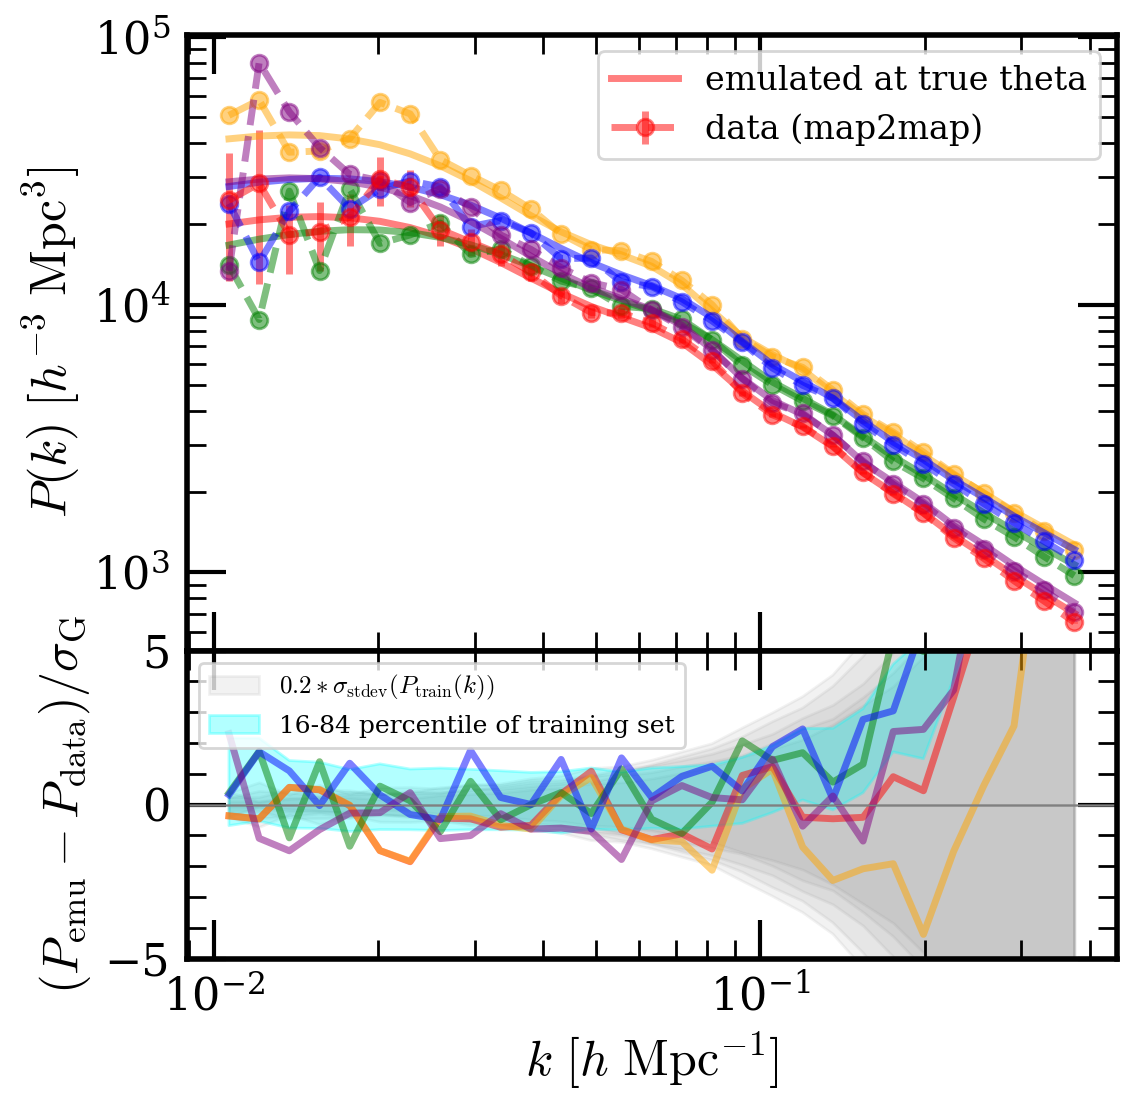

In [337]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,6), sharex=True, height_ratios=[2,1])
plt.subplots_adjust(hspace=0)
    
# a few examples
colors = ['red', 'orange', 'green', 'blue', 'purple']
for i in range(5):
    for pp in range(len(param_names)):
        cosmo_params[emu_param_names[pp]] = theta[i][pp]
    _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
                                                        **cosmo_params)

    label_true, label_emu, label_stdev = None, None, None
    if i==0:
        label_true = 'data (map2map)'
        label_emu = 'emulated at true theta'
        label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
    
    if i==0:
        axarr[0].errorbar(k, Pk_train[i], yerr=gaussian_error_pk_train[i], 
                          ls='--', marker='o', markersize=6, alpha=0.5, label=label_true, color=colors[i])
    else:
        axarr[0].plot(k, Pk_train[i], ls='--', marker='o', markersize=6, alpha=0.5, label=label_true, color=colors[i])
    axarr[0].plot(k, pk_model_unscaled, ls='-', alpha=0.5, label=label_emu, color=colors[i])
    
    axarr[1].plot(k, (pk_model_unscaled-Pk_train[i])/gaussian_error_pk_train[i], ls='-', alpha=0.5, color=colors[i])
    axarr[1].axhline(0, color='grey', lw=0.5)
    axarr[1].fill_between(k, -err_extra/gaussian_error_pk_train[i], 
                              err_extra/gaussian_error_pk_train[i], color='grey', alpha=0.1,
                              label=label_stdev)

axarr[1].fill_between(k, delta_pk_per_err_16, delta_pk_per_err_84, color='cyan', alpha=0.3,
                      label='16-84 percentile of training set')

plt.xscale('log')
axarr[0].set_yscale('log')
    
axarr[1].set_ylim(-5, 5)
    
axarr[0].legend(fontsize=12)
axarr[1].legend(fontsize=9)

axarr[1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=18)
axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=18)    
axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{data})/\sigma_\text{G}$', fontsize=18)


Text(0, 0.5, '$(P_\\text{emu}-P_\\text{data})/\\sigma_\\text{G}$')

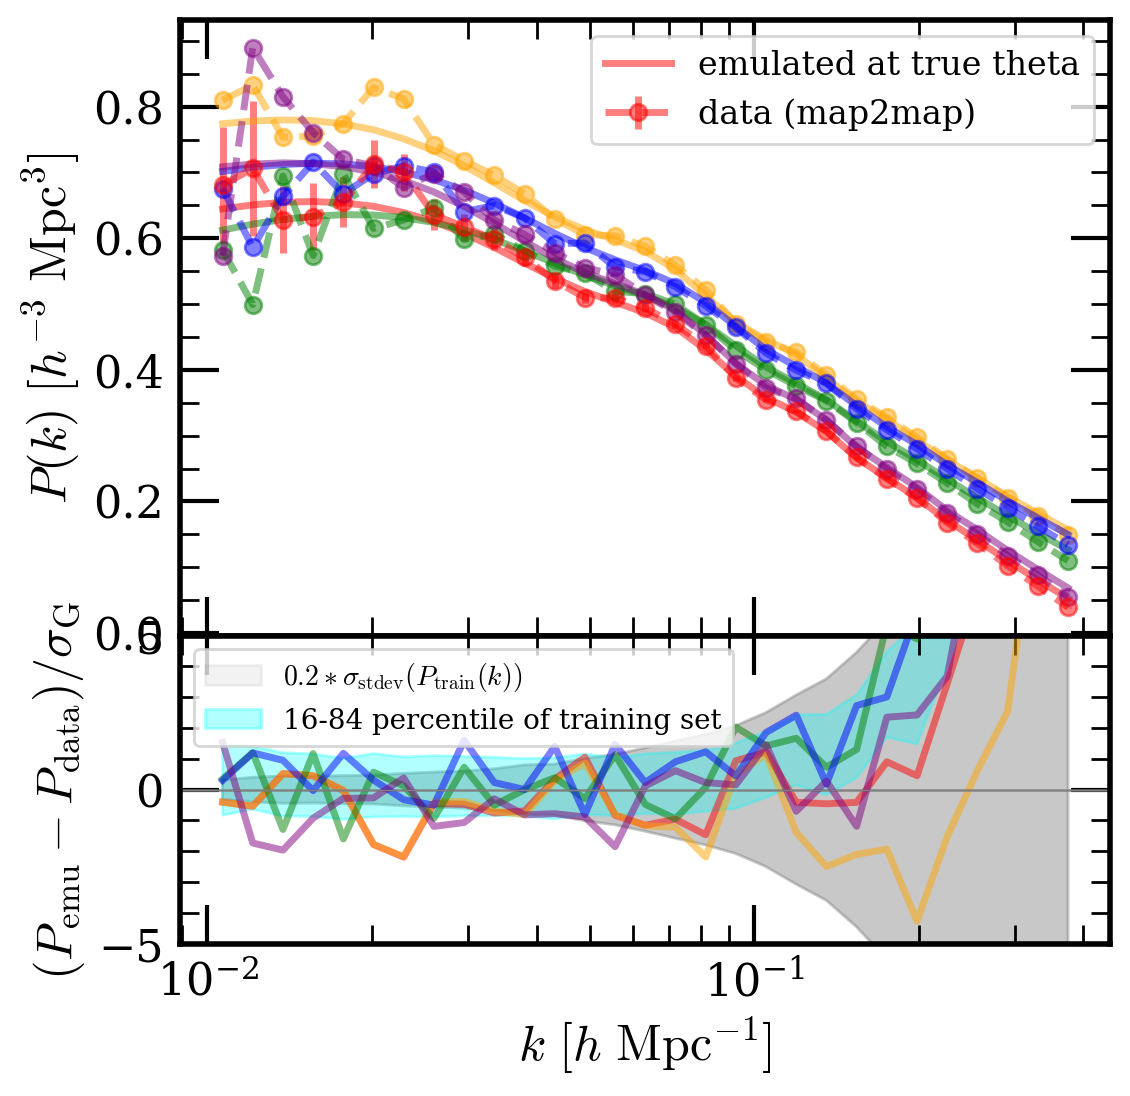

In [338]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(6,6), sharex=True, height_ratios=[2,1])
plt.subplots_adjust(hspace=0)

colors = ['red', 'orange', 'green', 'blue', 'purple']

for i in range(5):
    for pp in range(len(param_names)):
        cosmo_params[emu_param_names[pp]] = theta[i][pp]
    _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
                                                        **cosmo_params)
    pk_model_scaled = scaler.scale(pk_model_unscaled)
    label_true, label_emu, label_stdev = None, None, None
    if i==0:
        label_true = 'data (map2map)'
        label_emu = 'emulated at true theta'
        label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
    
    if i==0:
        axarr[0].errorbar(k, Pk_train_scaled[i], yerr=gaussian_error_pk_train_scaled[i], 
                          ls='--', marker='o', markersize=6, alpha=0.5, label=label_true, color=colors[i])
    else:
        axarr[0].plot(k, Pk_train_scaled[i], ls='--', marker='o', markersize=6, alpha=0.5, label=label_true, color=colors[i])
    axarr[0].plot(k, pk_model_scaled, ls='-', alpha=0.5, label=label_emu, color=colors[i])
    
    axarr[1].plot(k, (pk_model_scaled-Pk_train_scaled[i])/gaussian_error_pk_train_scaled[i], ls='-', alpha=0.5, color=colors[i])
    axarr[1].axhline(0, color='grey', lw=0.5)    
    
    axarr[1].fill_between(k, -err_extra_scaled/gaussian_error_pk_train_scaled[i], 
                              err_extra_scaled/gaussian_error_pk_train_scaled[i], color='grey', alpha=0.1,
                              label=label_stdev)

axarr[1].fill_between(k, deltas_pk_per_err_scaled_16, deltas_pk_per_err_scaled_84, color='cyan', alpha=0.3,
                      label='16-84 percentile of training set')

plt.xscale('log')
#axarr[0].set_yscale('log')
    
axarr[1].set_ylim(-5, 5)
    
axarr[0].legend(fontsize=12)
axarr[1].legend(fontsize=10)

axarr[1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=18)
axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=18)    
axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{data})/\sigma_\text{G}$', fontsize=18)


### Set up and run Moment Network model

Following demos at https://github.com/NiallJeffrey/MomentNetworks/tree/master

In [339]:
model_instance = demo.simple_leaky(n_dim, n_params, learning_rate=1e-4) 
regression = model_instance.model() 

29
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense_16 (Dense)            (None, 29)                870       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 29)                0         
                                                                 
 dense_17 (Dense)            (None, 58)                1740      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 58)                0         
                                                                 
 dense_18 (Dense)            (None, 29)                1711      
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 29)                0

In [340]:
print(theta_train.shape, Pk_train.shape)
print(theta_val.shape, Pk_val.shape)

(400, 3) (400, 29)
(50, 3) (50, 29)


Train initial model (basic MLP), as usual, on labeled data

In [357]:
history = regression.fit(Pk_train_scaled, theta_train,
                         epochs=1000, batch_size=32, shuffle=True,
                         validation_data=(Pk_val_scaled, theta_val))

Epoch 1/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 2/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 8/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 0.0010

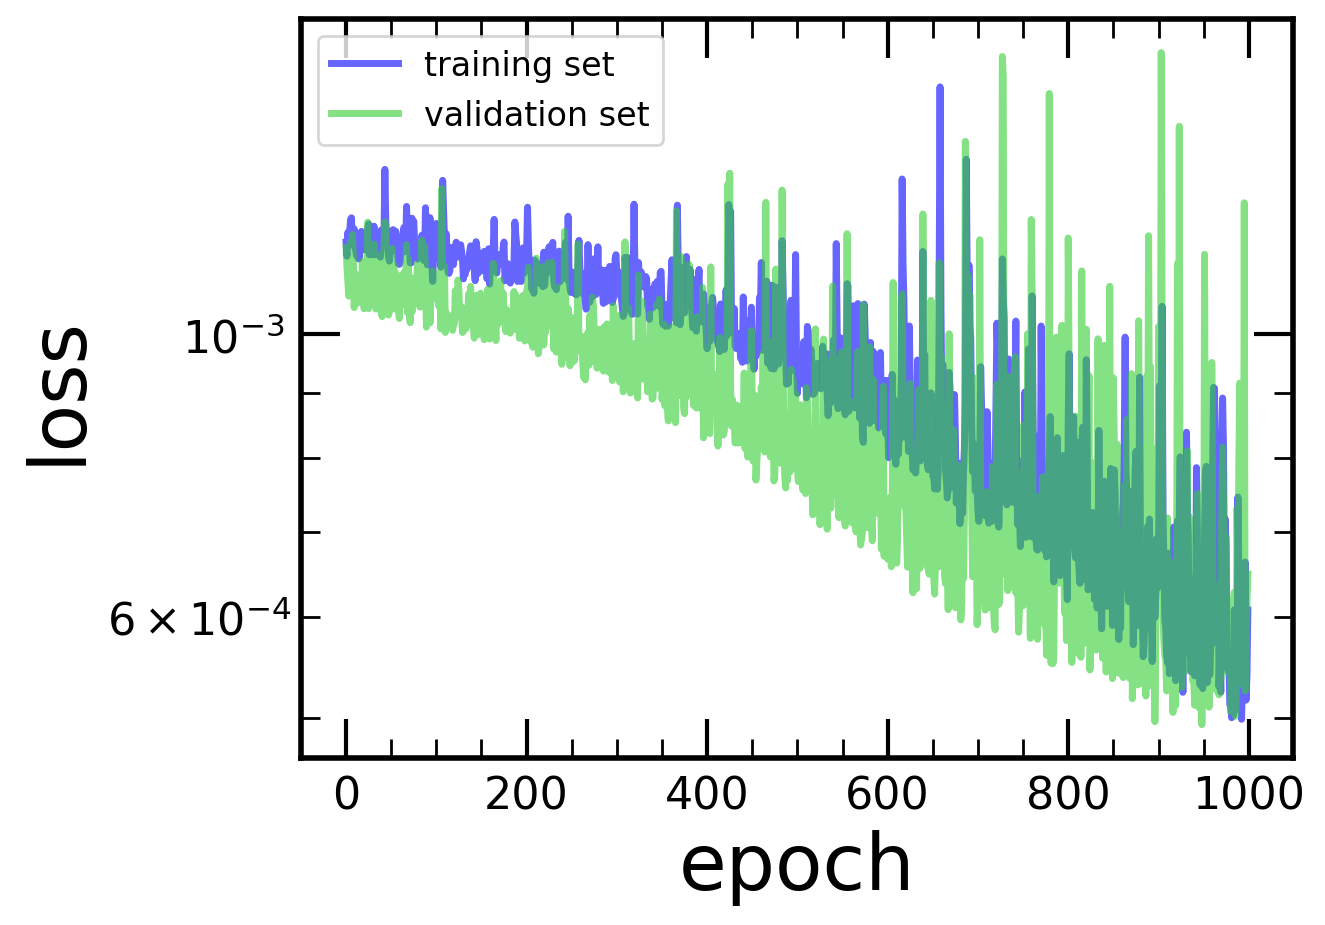

In [358]:
plt.plot(history.history['loss'], color='blue', label='training set', alpha=0.6)
plt.plot(history.history['val_loss'], color='limegreen', label='validation set', alpha=0.6)
plt.legend(fontsize=12)
plt.xlabel('epoch')
plt.ylabel('loss')

plt.yscale('log')
#plt.ylim(0, 0.005)

Get means and residuals

In [359]:
theta_train_pred = regression.predict(np.atleast_2d(Pk_train_scaled))
theta_val_pred = regression.predict(np.atleast_2d(Pk_val_scaled))

cov_dict = {}

training_covariances = []
training_covariances_val = []
count = 0
for i in range(n_params):
    for j in range(n_params):
        if j<i:
            cov_dict[(i,j)] = cov_dict[(j,i)]
            continue
        training_cov = ((theta_train[:,i]-theta_train_pred[:,i])* \
                        (theta_train[:,j]-theta_train_pred[:,j]))
        training_covariances.append(training_cov)
        
        training_cov_val = ((theta_val[:,i]-theta_val_pred[:,i])* \
                            (theta_val[:,j]-theta_val_pred[:,j]))
        training_covariances_val.append(training_cov_val)
        
        cov_dict[(i,j)] = count
        count += 1
        
training_covariances = np.array(training_covariances).T
training_covariances_val = np.array(training_covariances_val).T

n_covs = training_covariances.shape[1]

2/2 [==============================] - 0s 3ms/step


Set up and train model on the residuals

In [360]:
model_instance = demo.simple_leaky(n_dim, n_covs, learning_rate=1e-3)
regression_var_unknown_mean = model_instance.model()

29
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense_24 (Dense)            (None, 29)                870       
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 29)                0         
                                                                 
 dense_25 (Dense)            (None, 58)                1740      
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 58)                0         
                                                                 
 dense_26 (Dense)            (None, 29)                1711      
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 29)                0

In [361]:
history_var = regression_var_unknown_mean.fit(Pk_train_scaled,
                                          training_covariances,
                                          epochs=200, batch_size=32, shuffle=True,
                                          validation_data = (Pk_val_scaled,
                                                             training_covariances_val))

Epoch 1/200
13/13 [==============================] - 1s 11ms/step - loss: 1.8295e-06 - val_loss: 1.6215e-06
Epoch 2/200
13/13 [==============================] - 0s 3ms/step - loss: 1.0402e-06 - val_loss: 7.4693e-07
Epoch 3/200
13/13 [==============================] - 0s 3ms/step - loss: 7.6614e-07 - val_loss: 7.7162e-07
Epoch 4/200
13/13 [==============================] - 0s 3ms/step - loss: 7.4199e-07 - val_loss: 7.9000e-07
Epoch 5/200
13/13 [==============================] - 0s 4ms/step - loss: 7.8681e-07 - val_loss: 7.5391e-07
Epoch 6/200
13/13 [==============================] - 0s 3ms/step - loss: 7.7275e-07 - val_loss: 8.8052e-07
Epoch 7/200
13/13 [==============================] - 0s 3ms/step - loss: 7.6971e-07 - val_loss: 7.5348e-07
Epoch 8/200
13/13 [==============================] - 0s 3ms/step - loss: 7.5836e-07 - val_loss: 7.5075e-07
Epoch 9/200
13/13 [==============================] - 0s 3ms/step - loss: 7.2904e-07 - val_loss: 7.3666e-07
Epoch 10/200
13/13 [================

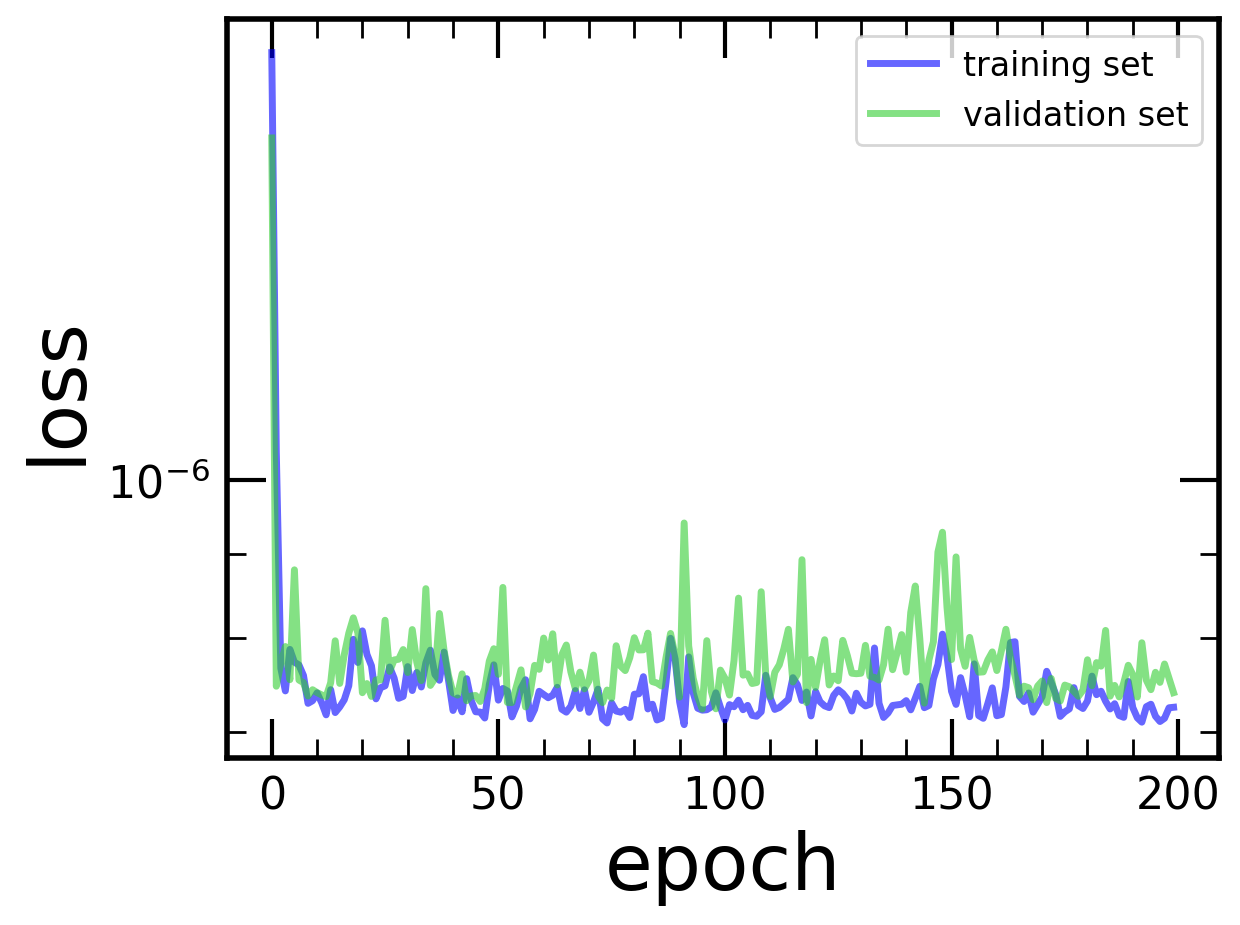

In [363]:
plt.plot(history_var.history['loss'], color='blue', label='training set', alpha=0.6)
plt.plot(history_var.history['val_loss'], color='limegreen', label='validation set', alpha=0.6)
plt.legend(fontsize=12)
plt.xlabel('epoch')
plt.ylabel('loss')

plt.yscale('log')
#plt.ylim(0, 0.005)

### Set up explicit likelihood, MCMC

In [345]:
# for emcee
n_burn = 40
n_steps = 200 # 50000
n_walkers = 4 * n_params

In [346]:
# for emcee
def log_prior(theta):
    for pp in range(len(param_names)):
       if (theta[pp] < dict_bounds[param_names[pp]][0]) or (theta[pp] >= dict_bounds[param_names[pp]][1]):
           return -np.inf
    return 0.0

# for dynesty
def prior_transform(u):

    u_transformed = []
    for pp in range(len(param_names)):
        width = dict_bounds[param_names[pp]][1] - dict_bounds[param_names[pp]][0]
        min_bound = dict_bounds[param_names[pp]][0]
        
        u_t = width*u[pp] + min_bound
        u_transformed.append(u_t)           

    return np.array(u_transformed)

In [347]:
global pk_data, cov_inv

def log_likelihood(theta):
    for pp in range(len(param_names)):
        cosmo_params[emu_param_names[pp]] = theta[pp]
    _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=k, 
                                                **cosmo_params)
    pk_model = scaler.scale(pk_model_unscaled)
    diff = pk_data-pk_model
    # print(theta)
    # print(cosmo_params)
    # print(pk_data)
    # print(pk_model)
    # print(cov_inv[0,0], cov_inv[1,1], cov_inv[2,2])
    # print(-0.5*np.dot(diff,np.dot(cov_inv,diff)))
    
    # print()
    return -0.5*np.dot(diff,np.dot(cov_inv,diff))

def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

### Test on a model from the test set (held-out data)

In [348]:
idx_test = 0
pk_data = Pk_test_scaled[idx_test]

Moment network:

In [349]:
predicted_mean_obs_test = regression.predict(np.atleast_2d(pk_data))
predicted_var_obs_test = (regression_var_unknown_mean.predict(np.atleast_2d(pk_data))[0])

moment_network_param_cov_test = np.empty((n_params, n_params))

for i in range(n_params):
    for j in range(n_params):
        moment_network_param_cov_test[i,j] = predicted_var_obs_test[cov_dict[(i,j)]]
print(moment_network_param_cov_test)

1/1 [==============================] - 0s 51ms/step
[[ 8.70764488e-04 -7.49239916e-06 -1.24857773e-03]
 [-7.49239916e-06 -2.96269027e-05 -3.00266867e-04]
 [-1.24857773e-03 -3.00266867e-04  3.03760357e-03]]


In [350]:
moment_network_samples_test = np.array(np.random.multivariate_normal(predicted_mean_obs_test[0],
                                  moment_network_param_cov_test,int(1e6)),dtype=np.float32)
gc.collect()

/tmp/ipykernel_320047/975881696.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  moment_network_samples_test = np.array(np.random.multivariate_normal(predicted_mean_obs_test[0],


390600

Explicit likelihood setup

In [351]:
err_gaussian_scaled = gaussian_error_pk_test_scaled[idx_test]
var = err_gaussian_scaled**2
#var = err_gaussian_scaled**2 + err_extra_scaled**2
cov_inv = np.diag(1/var)

n_threads = 8


MCMC, Dynesty:

In [352]:
with dynesty.pool.Pool(n_threads, log_likelihood, prior_transform) as pool:
    sampler_test = dynesty.NestedSampler(pool.loglike, pool.prior_transform, n_params, 
                                         nlive=20, bound='single')
    sampler_test.run_nested(dlogz=0.01)

301it [03:04,  1.63it/s, +20 | bound: 52 | nc: 1 | ncall: 2251 | eff(%): 14.388 | loglstar:   -inf < -77.527 <    inf | logz: -87.572 +/-  0.643 | dlogz:  0.000 >  0.010]


In [353]:
results_test = sampler_test.results
samples_dynesty_test = results_test.samples_equal()
print(samples_dynesty_test.shape)

(321, 3)


MCMC, emcee:

In [354]:
run_emcee = False
if run_emcee:
    rng = np.random.default_rng(seed=42)
    theta_0 = np.array([[rng.uniform(low=dict_bounds[param_name][0],high=dict_bounds[param_name][1]) 
                        for param_name in param_names] for _ in range(n_walkers)])

    start = time.time()
    if n_threads>1:
        with Pool(processes=n_threads) as pool:
            sampler_emcee = emcee.EnsembleSampler(n_walkers, n_params, log_posterior, pool=pool)
            _ = sampler_emcee.run_mcmc(theta_0, n_steps, progress=True) 
    else:
        sampler_emcee = emcee.EnsembleSampler(n_walkers, n_params, log_posterior)
        _ = sampler_emcee.run_mcmc(theta_0, n_steps, progress=True) 
    end = time.time()

    print(f"Time: {end-start} s ({(end-start)/60} min)")

    samples_emcee = sampler_emcee.get_chain(discard=n_burn, flat=True, thin=1)
    gc.collect()

### Plot contours

In [355]:
param_label_dict = {'omega_cold': r'$\Omega_\mathrm{m}$',
                'sigma8_cold': r'$\sigma_{8}$',
                'sigma_8': r'$\sigma_{8}$',
                'hubble': r'$h$',
                'h': r'$h$',
                'ns': r'$n_\mathrm{s}$',
                'n_s': r'$n_\mathrm{s}$',
                'omega_baryon': r'$\Omega_\mathrm{b}$',}
param_labels = [param_label_dict[param_name] for param_name in param_names]
extents = [dict_bounds[param_name] for param_name in param_names]

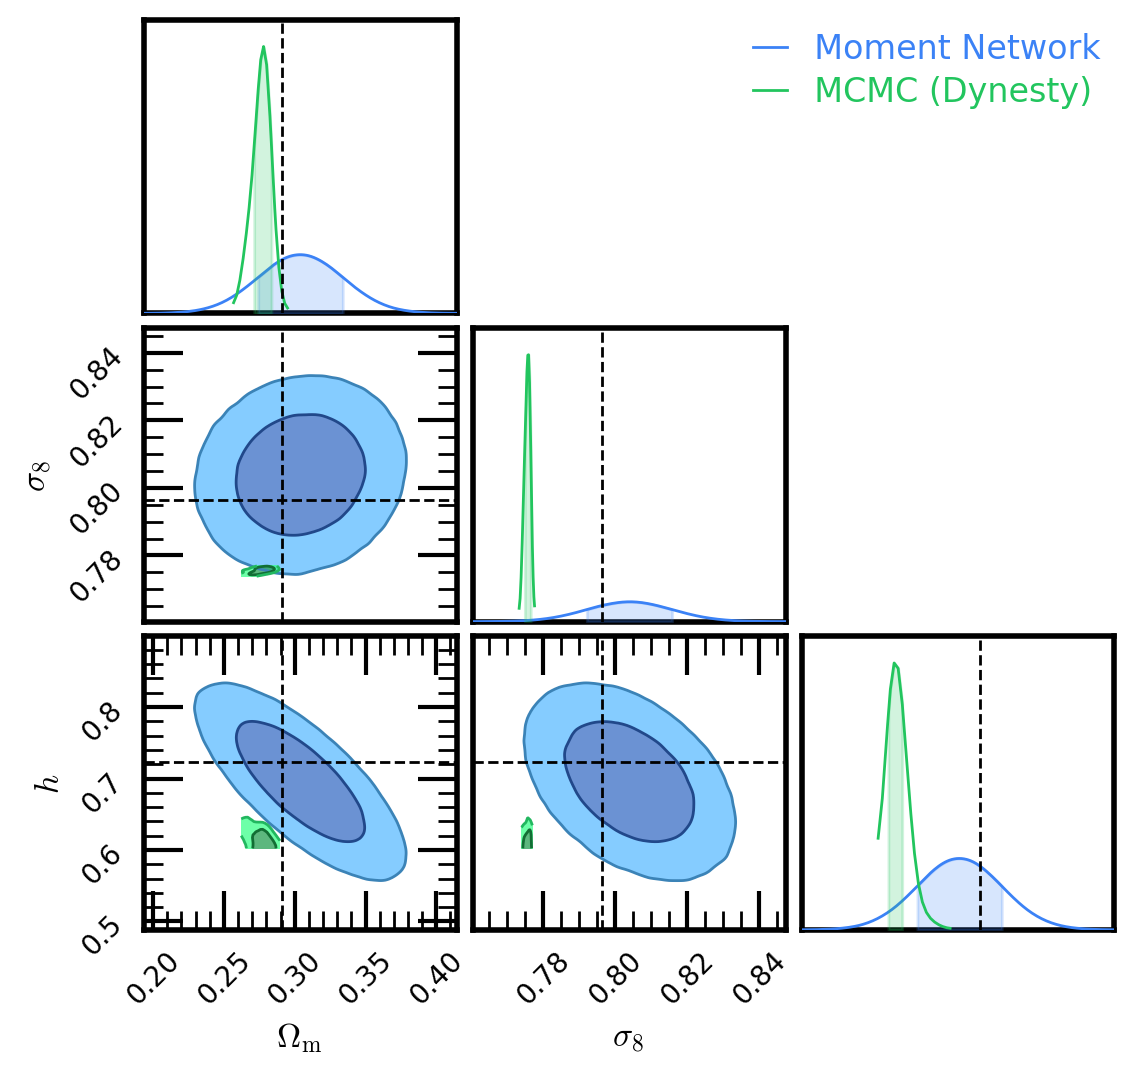

In [366]:
c = chainconsumer.ChainConsumer()

c.add_chain(chainconsumer.Chain(
            samples=pd.DataFrame(moment_network_samples_test, columns=param_names),
            name='Moment Network', color='blue')
            )

if run_emcee:
    c.add_chain(chainconsumer.Chain(
                samples=pd.DataFrame(samples_emcee, columns=param_names),
                name='MCMC (emcee)', color='purple', ls='--',
                smooth=1, bins=10)
                )

c.add_chain(chainconsumer.Chain(
            samples=pd.DataFrame(samples_dynesty_test, columns=param_names),
            name='MCMC (Dynesty)', color='green', 
            smooth=2, bins=5)
            )

c.set_plot_config(
    chainconsumer.PlotConfig(
        flip=True,
        labels=param_label_dict,
        contour_label_font_size=12,
        #extents=dict_bounds,
    )
)

truth_loc = dict(zip(param_names, theta_test[idx_test]))
c.add_truth(chainconsumer.Truth(location=truth_loc))

fig = c.plotter.plot(figsize = (6,6) )
if save_plots:
    plt.savefig(f'{plot_dir}/contours_test{idx_test}{tag_pk}{tag_fit}.png')